# DataSet 
https://archive.ics.uci.edu/dataset/332/online+news+popularity

Данные о публикации новостей и количество репостов в социальных сетях. Этот набор данных суммирует гетерогенный набор функций о статьях, опубликованных Mashable за два года. Цель состоит в том, чтобы предсказать количество акций в социальных сетях (популярность).

# Задача:
- Уменьшить количество анализируемых признаков, применить методы PCA и t-SNE.
- Выполнить кластеризацию используя алгоритмы k-means, c-means.

Цель: Предсказать популярность 

# План:
1. Предварительный анализ данных. Проверить наличие пропусков, выбросов, дисбаланса. Анализ распределения целевой переменной (shares).

2. Снижение размерности. PCA: Проверить долю объяснённой дисперсии для выбора оптимального количества компонент. t-SNE: Визуализация данных в 2D/3D для изучения структуры.

3. Кластеризация. K-Means: Определить оптимальное количество кластеров (методы локтя и силуэта). C-Means (Fuzzy C-Means): Проверить размытые кластеры и их характеристики.

4. Анализ результатов. Оценить качество кластеризации. Связь кластеров с популярностью статей. Выявление закономерностей, влияющих на количество репостов.

In [95]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
online_news_popularity = fetch_ucirepo(id=332) 
  
# data (as pandas dataframes) 
X = online_news_popularity.data.features 
y = online_news_popularity.data.targets

In [96]:
X.head(3)

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,...,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.5,-0.1875,0.0,0.1875
1,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,...,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.0,0.0000,0.5,0.0000
2,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,...,0.495833,0.100000,1.0,-0.466667,-0.800,-0.133333,0.0,0.0000,0.5,0.0000


In [97]:
y.head(3)

,shares
0,593
1,711
2,1500


Датасет содержит 58 признаков, описывающих статьи, опубликованные на Mashable. Эти признаки включают:

Лексические характеристики: число слов в заголовке (n_tokens_title), количество уникальных токенов (n_unique_tokens), длина токенов (average_token_length), субъективность заголовка (title_subjectivity), полярность (title_sentiment_polarity) и т. д.

Структурные характеристики: количество ссылок (num_hrefs), количество изображений (num_imgs), количество видео (num_videos).

Показатели эмоциональной окраски: средняя положительная (avg_positive_polarity) и отрицательная (avg_negative_polarity) тональность статьи.

Целевая переменная (shares): количество репостов статьи в социальных сетях (популярность).

# EDA - исследование данных

In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [99]:
# Проверка пропущенных значений в X
missing_values = X.isnull().sum()
print("Пропущенные значения в X:\n", missing_values[missing_values > 0])

Пропущенные значения в X:
 Series([], dtype: int64)


In [100]:
X.describe()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,...,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,10.398749,546.514731,0.548216,0.996469,0.689175,10.883690,3.293638,4.544143,1.249874,4.548239,...,0.353825,0.095446,0.756728,-0.259524,-0.521944,-0.107500,0.282353,0.071425,0.341843,0.156064
std,2.114037,471.107508,3.520708,5.231231,3.264816,11.332017,3.855141,8.309434,4.107855,0.844406,...,0.104542,0.071315,0.247786,0.127726,0.290290,0.095373,0.324247,0.265450,0.188791,0.226294
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000
25%,9.000000,246.000000,0.470870,1.000000,0.625739,4.000000,1.000000,1.000000,0.000000,4.478404,...,0.306244,0.050000,0.600000,-0.328383,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000
50%,10.000000,409.000000,0.539226,1.000000,0.690476,8.000000,3.000000,1.000000,0.000000,4.664082,...,0.358755,0.100000,0.800000,-0.253333,-0.500000,-0.100000,0.150000,0.000000,0.500000,0.000000
75%,12.000000,716.000000,0.608696,1.000000,0.754630,14.000000,4.000000,4.000000,1.000000,4.854839,...,0.411428,0.100000,1.000000,-0.186905,-0.300000,-0.050000,0.500000,0.150000,0.500000,0.250000
max,23.000000,8474.000000,701.000000,1042.000000,650.000000,304.000000,116.000000,128.000000,91.000000,8.041534,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000


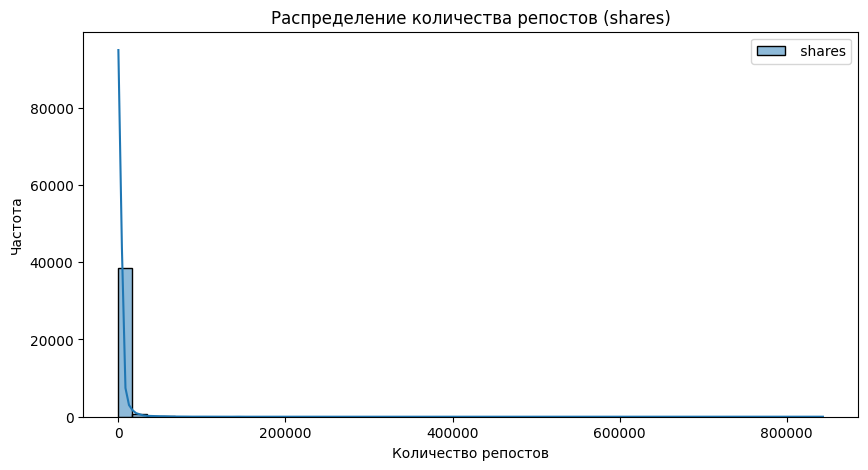

In [101]:
# Анализ распределения целевой переменной y
plt.figure(figsize=(10, 5))
sns.histplot(y, bins=50, kde=True)
plt.title("Распределение количества репостов (shares)")
plt.xlabel("Количество репостов")
plt.ylabel("Частота")
plt.show()

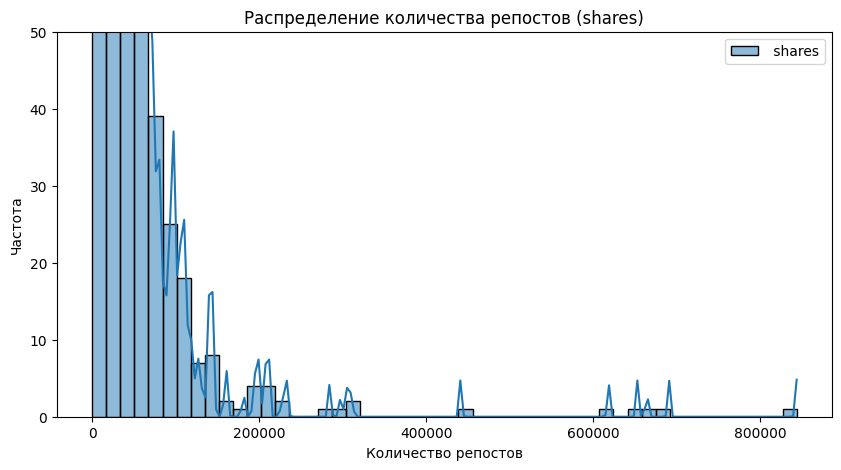

In [102]:
plt.figure(figsize=(10, 5))
sns.histplot(y, bins=50, kde=True)
plt.title("Распределение количества репостов (shares)")
plt.xlabel("Количество репостов")
plt.ylabel("Частота")
plt.ylim(0, 50)
plt.show()

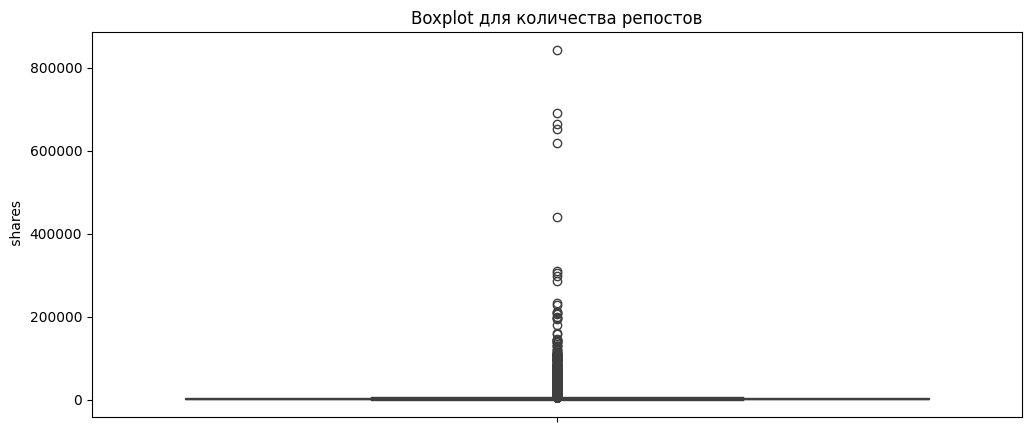

In [103]:
# Поиск выбросов с помощью boxplot
plt.figure(figsize=(12, 5))
sns.boxplot(y[' shares'])
plt.title("Boxplot для количества репостов")
plt.show()

Выбросы:

Основная масса данных сконцентрирована в диапазоне 0–250000. Несколько точек выбиваются за этот предел:

~300000 (3 точки)

~450000 (1 точка)

620000–750000 (4 точки)

>800000 (1 точка)

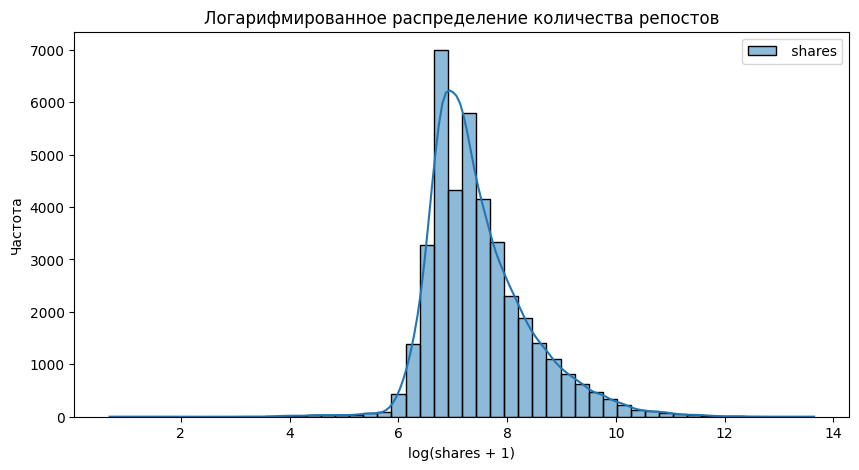

In [104]:
# Логарифмируем y для лучшей визуализации
plt.figure(figsize=(10, 5))
sns.histplot(np.log1p(y), bins=50, kde=True)
plt.title("Логарифмированное распределение количества репостов")
plt.xlabel("log(shares + 1)")
plt.ylabel("Частота")
plt.show()

Пропущенные значения отсутствуют, что упрощает дальнейший анализ и обработку данных.

Распределение признаков:

Некоторые признаки имеют экстремальные значения (например, n_tokens_content, num_hrefs, num_imgs и т. д.), что может указывать на наличие выбросов.

Средние и медианные значения признаков значительно отличаются от их максимальных значений, что подтверждает размах в данных.

Распределение целевой переменной (shares):

Наблюдается сильная асимметрия с высокой концентрацией значений вблизи нуля.

Присутствуют выбросы на уровнях 30K, 43K, 60K, 65K-70K и 80K+, которые встречаются редко.

Логарифмирование целевой переменной может улучшить анализ и предсказательную способность моделей.

# Удаление выбросов с помощью метода IQR

In [105]:
Q1 = np.percentile(y, 25)
Q3 = np.percentile(y, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

mask = (y >= lower_bound) & (y <= upper_bound)
X_cleaned = X[mask]
y_cleaned = y[mask]

print(f"Размер данных после удаления выбросов: {X_cleaned.shape}, {y_cleaned.shape}")

Размер данных после удаления выбросов: (39644, 58), (39644, 1)


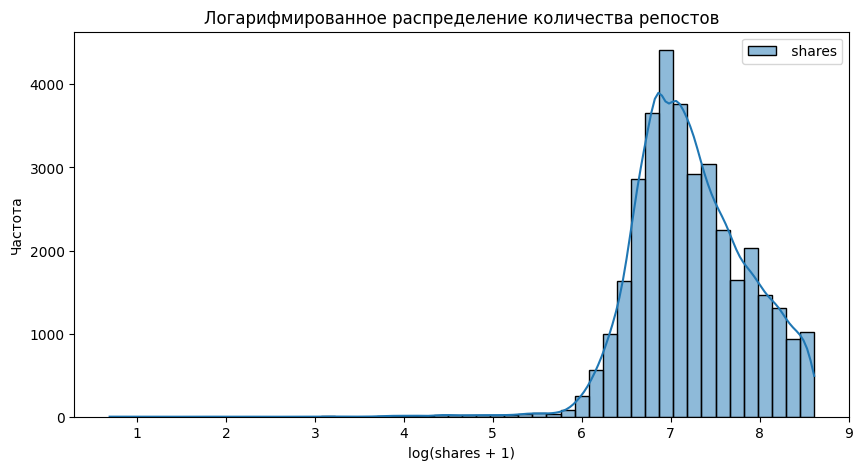

In [106]:
# Логарифмируем 'shares' для лучшей визуализации
plt.figure(figsize=(10, 5))
sns.histplot(np.log1p(y_cleaned), bins=50, kde=True)
plt.title("Логарифмированное распределение количества репостов")
plt.xlabel("log(shares + 1)")
plt.ylabel("Частота")
plt.show()

# отбор признаков
Корреляция признаков с целевой переменной

In [107]:
# Корреляция признаков с целевой переменной
correlation = X.corrwith(y)
# Выводим топ-10 наиболее коррелирующих признаков
top_features = correlation.abs().sort_values(ascending=False).head(10)
print("Топ-10 признаков по корреляции с целевой переменной:\n", top_features)

Топ-10 признаков по корреляции с целевой переменной:
 LDA_00                         NaN
LDA_01                         NaN
LDA_02                         NaN
LDA_03                         NaN
LDA_04                         NaN
abs_title_sentiment_polarity   NaN
abs_title_subjectivity         NaN
average_token_length           NaN
avg_negative_polarity          NaN
avg_positive_polarity          NaN
dtype: float64


Использование Lasso для отбора признаков

In [108]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

In [109]:
# Масштабируем данные для Lasso
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Применяем Lasso
lasso = Lasso(alpha=0.01)
lasso.fit(X_scaled, y)

In [111]:
# Отбираем признаки, имеющие ненулевые коэффициенты
lasso_selected_features = X.columns[(lasso.coef_ != 0)]
print("Отобранные признаки с помощью Lasso:\n", lasso_selected_features)

Отобранные признаки с помощью Lasso:
 Index([' n_tokens_title', ' n_tokens_content', ' n_unique_tokens',
       ' n_non_stop_words', ' n_non_stop_unique_tokens', ' num_hrefs',
       ' num_self_hrefs', ' num_imgs', ' num_videos', ' average_token_length',
       ' num_keywords', ' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min',
       ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg',
       ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares',
       ' self_reference_max_shares', ' self_reference_avg_sharess',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_subjectivity',
   

Lasso использует регуляризацию для выбора наиболее важных признаков. Ваши отобранные признаки включают:

Показатели, связанные с количеством токенов в заголовке и контенте.

Частотные показатели, такие как количество ключевых слов и изображений.

Показатели, связанные с каналами данных, например, канал "lifestyle", "entertainment", "bus", и т.д.

ЛДА-признаки (LDA_00, LDA_01 и т.д.), связанные с тематикой текста.

Это означает, что Lasso выбрал признаки, которые могут быть важными для предсказания целевой переменной (количество репостов). Эти признаки могут быть полезны для построения модели.

In [112]:
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor

In [ ]:
# Обучаем дерево решений
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X, y)

In [114]:
# Важность признаков
feature_importances = pd.Series(tree.feature_importances_, index=X.columns)
top_tree_features = feature_importances.sort_values(ascending=False).head(10)
print("Топ-10 признаков по важности для дерева решений:\n", top_tree_features)

Топ-10 признаков по важности для дерева решений:
 title_sentiment_polarity      0.127941
LDA_02                        0.102886
LDA_03                        0.078154
average_token_length          0.077426
kw_avg_avg                    0.068318
rate_positive_words           0.062610
self_reference_avg_sharess    0.044785
self_reference_max_shares     0.029920
kw_max_avg                    0.028454
LDA_01                        0.027072
dtype: float64


Дерево решений оценивает важность признаков на основе того, насколько они влияют на качество разделения данных.

Самыми важными признаками для дерева решений являются:

title_sentiment_polarity: показывает полярность заголовка.

LDA_02 и LDA_03: тематики, связанные с текстом.

average_token_length: средняя длина токенов в тексте.

Показатели, связанные с ключевыми словами и репостами, такие как kw_avg_avg, self_reference_avg_sharess и другие.

Из этих данных видно, что как Lasso, так и дерево решений выделяют схожие признаки, такие как LDA_02, LDA_03 и average_token_length, но также есть важные различия, например, полярность заголовка, которую выбрал только деревьев.

In [115]:
# Применяем PCA
pca = PCA(n_components=10)  # Уменьшаем до 10 компонент
X_pca = pca.fit_transform(X)

# Отображаем долю объясненной дисперсии
print(f"Доля объясненной дисперсии компонентами PCA: {pca.explained_variance_ratio_}")

Доля объясненной дисперсии компонентами PCA: [7.62824099e-01 1.63830471e-01 3.53264563e-02 3.20505344e-02
 4.92687632e-03 6.15851513e-04 2.87065436e-04 1.14858398e-04
 1.68396924e-05 3.49542323e-06]


PCA показывает, что первые две компоненты объясняют подавляющую долю дисперсии:

Первая компонента объясняет 76.28% дисперсии.

Вторая компонента объясняет 16.38% дисперсии.

Это означает, что первые две компоненты содержат большую часть информации, и вы можете использовать только их для дальнейшего анализа или моделирования, если хотите уменьшить размерность. Эти результаты также подтверждают, что данные имеют линейную структуру и могут быть эффективно сжаты с помощью PCA.

Уменьшить размерность с помощью методов PCA и t-SNE, а затем сравнить их результаты

In [116]:
from sklearn.manifold import TSNE

In [117]:
# Уменьшаем размерность с помощью PCA
pca = PCA(n_components=2)  # Уменьшаем размерность до 2
X_pca = pca.fit_transform(X)

In [118]:
# Преобразуем y в массив чисел для корректного отображения цвета
y_numeric = y.values.ravel()

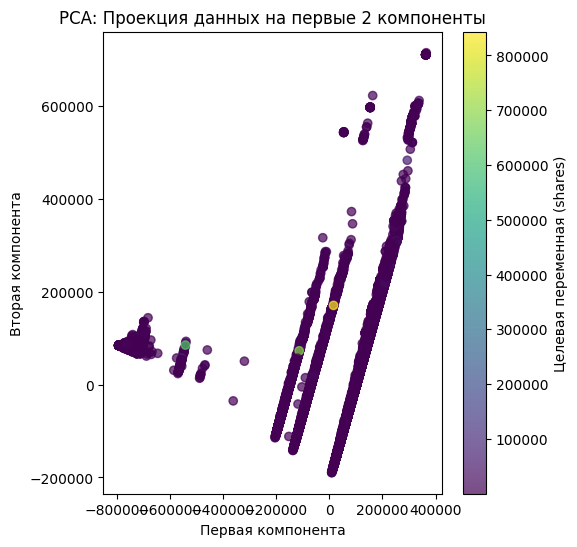

In [119]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_numeric, cmap='viridis', alpha=0.7)
plt.title('PCA: Проекция данных на первые 2 компоненты')
plt.xlabel('Первая компонента')
plt.ylabel('Вторая компонента')
plt.colorbar(scatter, label='Целевая переменная (shares)')

In [120]:
# Уменьшаем размерность с помощью t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

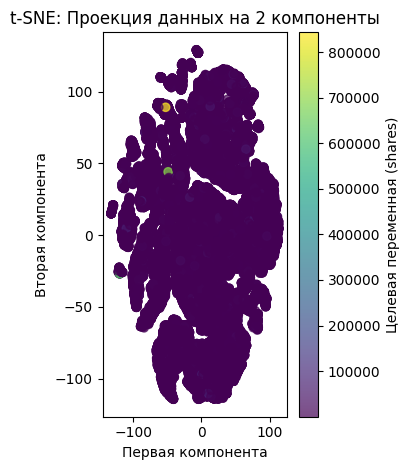

In [121]:
# Визуализация t-SNE
plt.subplot(1, 2, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_numeric, cmap='viridis', alpha=0.7)
plt.title('t-SNE: Проекция данных на 2 компоненты')
plt.xlabel('Первая компонента')
plt.ylabel('Вторая компонента')
plt.colorbar(label='Целевая переменная (shares)')

plt.tight_layout()
plt.show()

# Кластеризация

In [122]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist

In [123]:
# Функция Soft k-means
def soft_kmeans(X, k, beta=1.0, max_iters=100, tol=1e-4):
    np.random.seed(42)
    centers = X[np.random.choice(len(X), k, replace=False)]  # Инициализация центров кластеров
    for _ in range(max_iters):
        distances = cdist(X, centers)  # Вычисление расстояний
        weights = np.exp(-beta * distances)  # Вычисление вероятностей принадлежности
        weights /= weights.sum(axis=1, keepdims=True)  # Нормализация
        new_centers = weights.T @ X / weights.sum(axis=0)[:, None]  # Обновление центров
        if np.linalg.norm(new_centers - centers) < tol:  # Проверка сходимости
            break
        centers = new_centers
    clusters = weights.argmax(axis=1)  # Присвоение кластера по максимальному весу
    return clusters, centers

In [124]:
# Функция для кластеризации и визуализации
def cluster_and_plot(X_reduced, method_name):
    # K-Means
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    clusters_kmeans = kmeans.fit_predict(X_reduced)
    
    # Soft K-Means
    clusters_soft_kmeans, _ = soft_kmeans(X_reduced, k=3, beta=1.0)

    # Проверяем, достаточно ли кластеров для silhouette_score
    unique_kmeans = np.unique(clusters_kmeans)
    unique_soft_kmeans = np.unique(clusters_soft_kmeans)

    silhouette_kmeans = silhouette_score(X_reduced, clusters_kmeans) if len(unique_kmeans) > 1 else np.nan
    silhouette_soft_kmeans = silhouette_score(X_reduced, clusters_soft_kmeans) if len(unique_soft_kmeans) > 1 else np.nan

    # Визуализация
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=clusters_kmeans, palette="viridis")
    plt.title(f'K-Means Clustering ({method_name})\nSilhouette: {silhouette_kmeans:.2f}' if not np.isnan(silhouette_kmeans) else "K-Means Clustering (Ошибка Silhouette)")

    plt.subplot(1, 2, 2)
    sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=clusters_soft_kmeans, palette="coolwarm")
    plt.title(f'Soft K-Means Clustering ({method_name})\nSilhouette: {silhouette_soft_kmeans:.2f}' if not np.isnan(silhouette_soft_kmeans) else "Soft K-Means Clustering (Ошибка Silhouette)")

    plt.show()

C:\Users\mmd28\AppData\Local\Temp\ipykernel_10960\3992439369.py:8: RuntimeWarning: invalid value encountered in divide
  weights /= weights.sum(axis=1, keepdims=True)  # Нормализация


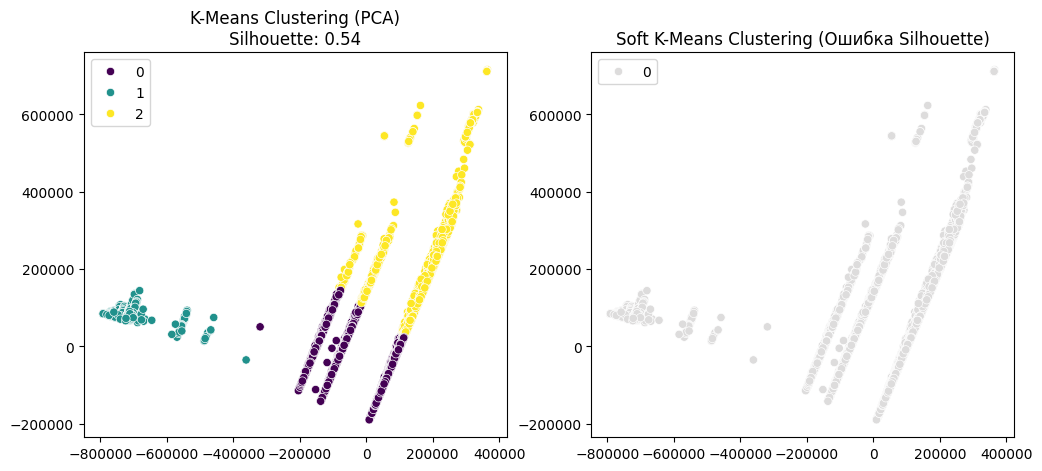

In [125]:
# Кластеризация после PCA
cluster_and_plot(X_pca[:, :2], "PCA")

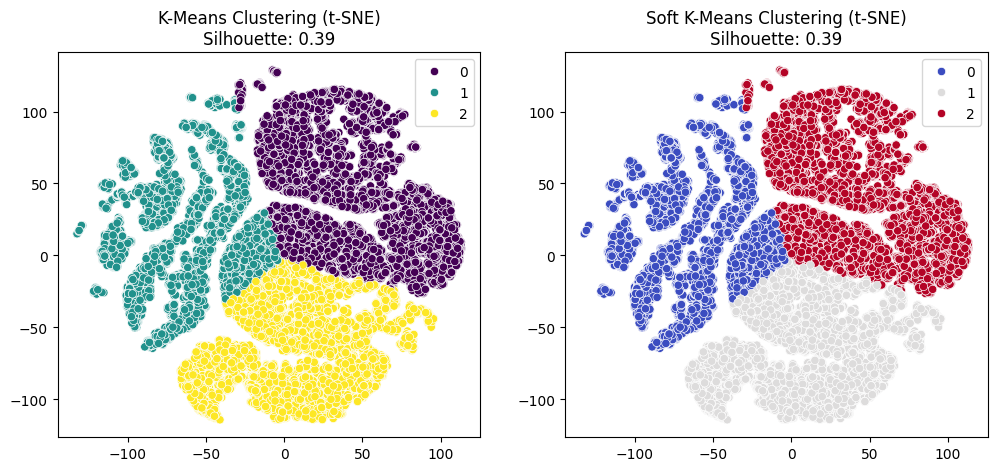

In [126]:
# Кластеризация после t-SNE
cluster_and_plot(X_tsne, "t-SNE")

# Предсказание популярности новостей

In [127]:
from sklearn.model_selection import train_test_split

In [128]:
# Применяем K-Means для кластеризации на X_pca (или X_tsne, если используем t-SNE)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

In [129]:
# Нахождение самого крупного кластера
largest_cluster = np.argmax(np.bincount(clusters))  # Индекс самого крупного кластера

In [130]:
# Создаем целевую переменную: 1 для объектов в самом крупном кластере, 0 - для остальных
y_target = (clusters == largest_cluster).astype(int)

In [131]:
# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_target, test_size=0.3, random_state=42)

In [132]:
# Выводим размеры выборок
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (27750, 2)
Размер тестовой выборки: (11894, 2)


# Обучению модели для дальнейшего анализа или прогноза

In [133]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [134]:
# Определим модели
logreg = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)
svc = SVC(random_state=42)

In [135]:
# Определим параметры для поиска
param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

In [136]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10]
}

In [ ]:
# Выполним поиск по сетке для каждой модели
grid_logreg = GridSearchCV(logreg, param_grid_logreg, cv=5, n_jobs=-1)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, n_jobs=-1)

In [139]:
# Обучаем модели
grid_logreg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'solver': ['liblinear', 'saga']})

In [140]:
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, None],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]})

In [143]:
# Сравниваем лучшие гиперпараметры
print("Лучшие параметры для логистической регрессии:", grid_logreg.best_params_)
print("Лучшие параметры для случайного леса:", grid_rf.best_params_)

Лучшие параметры для логистической регрессии: {'C': 0.01, 'solver': 'liblinear'}
Лучшие параметры для случайного леса: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}


In [158]:
# Выбираем лучшую модель
best_model_logr = grid_logreg.best_estimator_ 

In [159]:
# Предсказание на тестовой выборке
y_pred = best_model_logr.predict(X_test)

In [160]:
print("Точность модели:", accuracy_score(y_test, y_pred))
print("Отчет о классификации:\n", classification_report(y_test, y_pred))

Точность модели: 0.9243315957625694
Отчет о классификации:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90      4145
           1       1.00      0.88      0.94      7749

    accuracy                           0.92     11894
   macro avg       0.91      0.94      0.92     11894
weighted avg       0.94      0.92      0.93     11894



In [ ]:
# Выбираем лучшую модель
best_model = grid_rf.best_estimator_ 

In [152]:
# Предсказание на тестовой выборке
y_pred = best_model.predict(X_test)

In [153]:
# Оценка модели
print("Точность модели:", accuracy_score(y_test, y_pred))
print("Отчет о классификации:\n", classification_report(y_test, y_pred))

Точность модели: 0.9995796199764587
Отчет о классификации:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4145
           1       1.00      1.00      1.00      7749

    accuracy                           1.00     11894
   macro avg       1.00      1.00      1.00     11894
weighted avg       1.00      1.00      1.00     11894



# Кросс-валидайия случайного леса

In [154]:
from sklearn.model_selection import cross_val_score

In [161]:
# Инициализация модели случайного леса с наилучшими гиперпараметрами
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [162]:
# Проведение кросс-валидации
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')

In [163]:
# Вывод результатов
print(f'Кросс-валидация (точность): {cv_scores}')
print(f'Средняя точность по кросс-валидации: {np.mean(cv_scores):.4f}')
print(f'Стандартное отклонение точности: {np.std(cv_scores):.4f}')

Кросс-валидация (точность): [0.9990991  0.99981982 0.99981982 0.99963964 0.99945946]
Средняя точность по кросс-валидации: 0.9996
Стандартное отклонение точности: 0.0003


Модель случайного леса показывает исключительную точность и стабильность при кросс-валидации, что делает её хорошим выбором для предсказаний на новых данных. С учётом этого, модель готова к использованию на тестовой выборке и для дальнейшего развертывания.

# Оценка модели кластеризации

In [164]:
import joblib
from sklearn.metrics import silhouette_score, classification_report

In [165]:
# Оценка модели кластеризации (KMeans)
clusters_test = kmeans.predict(X_test)  # Прогнозируем кластеры на тестовой выборке
silhouette_score_test = silhouette_score(X_test, clusters_test)  # Вычисляем метрику силуэта

In [166]:
print(f"Silhouette Score для кластеризации на тестовой выборке: {silhouette_score_test:.4f}")

Silhouette Score для кластеризации на тестовой выборке: 0.5295


Результат в 0.5295 говорит о том, что кластеры не являются идеальными, но модель KMeans всё же нашла некоторую структуру в данных. Это может быть приемлемым результатом для некоторых типов данных, но также может свидетельствовать о том, что улучшение модели или изменение количества кластеров могло бы дать более чёткие результаты.

# Сохранение моделей

In [ ]:
# Модель кластеризации (KMeans)
kmeans_model = KMeans(n_clusters=3, random_state=42)
kmeans_model.fit(X_train)

In [ ]:
# Модель Random Forest для предсказания
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

In [ ]:
# Стандартизатор
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 

In [ ]:
# Сохранение моделей и трансформеров
joblib.dump(kmeans_model, 'kmeans_model.pkl')  # Сохраняем модель кластеризации
joblib.dump(rf_model, 'rf_model.pkl')  # Сохраняем модель Random Forest
joblib.dump(scaler, 'scaler.pkl')  # Сохраняем стандартизатор

print("Модели и трансформеры успешно сохранены!")